In [2]:
import poppy
import proper
import roman_phasec_proper
import numpy as np
import cupy as cp
import astropy.units as u
import astropy.io.fits as fits
from scipy.ndimage import rotate

from pathlib import Path
from glob import glob

from importlib import reload
import misc

use_opds = False

pupil_diam_pix = 1000
wf_dir = Path('/groups/douglase/kians-data-files/roman-cgi-wfs/spc-wide')

optics = ['polmap', 'primary', 'secondary', 'poma_fold', 'm3', 'm4', 'm5', 'tt_fold', 'fsm', 'oap1', 
          'focm', 'oap2', 'dm1', 'dm2', 'oap3', 'fold3', 'oap4', 'pupilmask', 'oap5', 'fpm', 'oap6',
          'lyotstop', 'oap7', 'fieldstop', 'oap8', 'filter', 
          'imaging_lens_lens1', 'imaging_lens_lens2', 'image']

poppy_fnames = []
proper_fnames = []
for i,optic in enumerate(optics):
    if use_opds:
        if optic=='fpm' or optic=='lyotstop' or optic=='fieldstop' or optic=='lens2' or optic=='fold4' or optic=='image':
            poppy_fname = glob( str(wf_dir/('*'+optic+'_poppy.fits')) )
        elif optic=='lens1': poppy_fname = glob( str(wf_dir/('*lens_opd_poppy.fits')) )
        else: poppy_fname = glob( str(wf_dir/('*'+optic+'_opd_poppy.fits')) )
    else:
        poppy_fname = glob( str(wf_dir/('*'+optic+'_poppy.fits')) )
        
    proper_fname = glob( str(wf_dir/('*'+optic+'_proper.fits')) )
    
    print(i)
    print(poppy_fname)
    print(proper_fname)
    print()
    
    if len(proper_fname)>0 and len(poppy_fname)>0:
        poppy_fnames.append(poppy_fname[0])
        proper_fnames.append(proper_fname[0])

def rotate_180(arr):
    M = arr.shape[0]
    N = arr.shape[1]
    rot_arr = np.zeros(shape=(N,M))
    for i in range(M):
        for j in range(N):
            rot_arr[i, N-1-j] = arr[M-1-i, j]
    return rot_arr

0
[]
['/groups/douglase/kians-data-files/roman-cgi-wfs/spc-wide/polmap_proper.fits']

1
['/groups/douglase/kians-data-files/roman-cgi-wfs/spc-wide/primary_poppy.fits']
['/groups/douglase/kians-data-files/roman-cgi-wfs/spc-wide/primary_proper.fits']

2
['/groups/douglase/kians-data-files/roman-cgi-wfs/spc-wide/secondary_poppy.fits']
['/groups/douglase/kians-data-files/roman-cgi-wfs/spc-wide/secondary_proper.fits']

3
['/groups/douglase/kians-data-files/roman-cgi-wfs/spc-wide/poma_fold_poppy.fits']
['/groups/douglase/kians-data-files/roman-cgi-wfs/spc-wide/poma_fold_proper.fits']

4
['/groups/douglase/kians-data-files/roman-cgi-wfs/spc-wide/m3_poppy.fits']
['/groups/douglase/kians-data-files/roman-cgi-wfs/spc-wide/m3_proper.fits']

5
['/groups/douglase/kians-data-files/roman-cgi-wfs/spc-wide/m4_poppy.fits']
['/groups/douglase/kians-data-files/roman-cgi-wfs/spc-wide/m4_proper.fits']

6
['/groups/douglase/kians-data-files/roman-cgi-wfs/spc-wide/m5_poppy.fits']
['/groups/douglase/kians-data

In [ ]:
# THE DM IS PROBABLY OFF

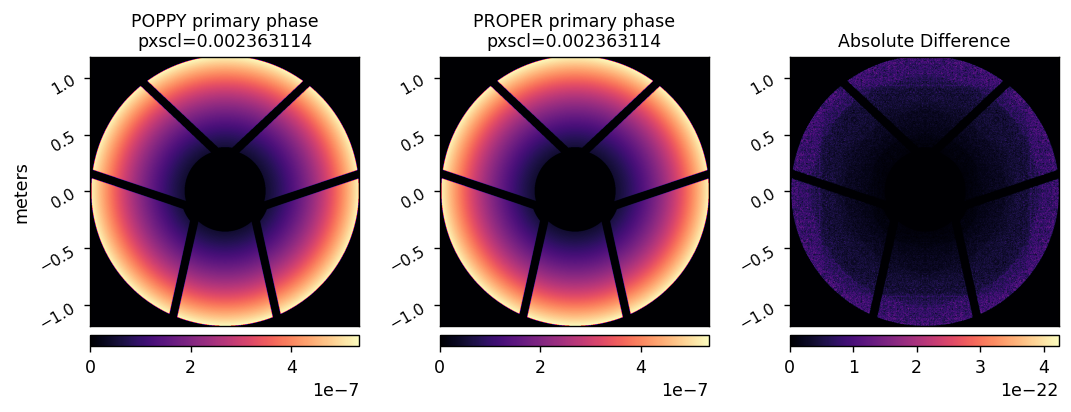

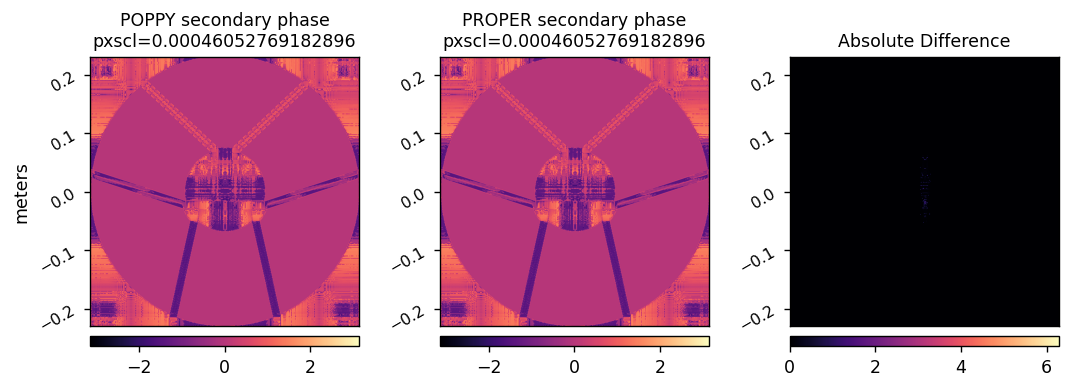

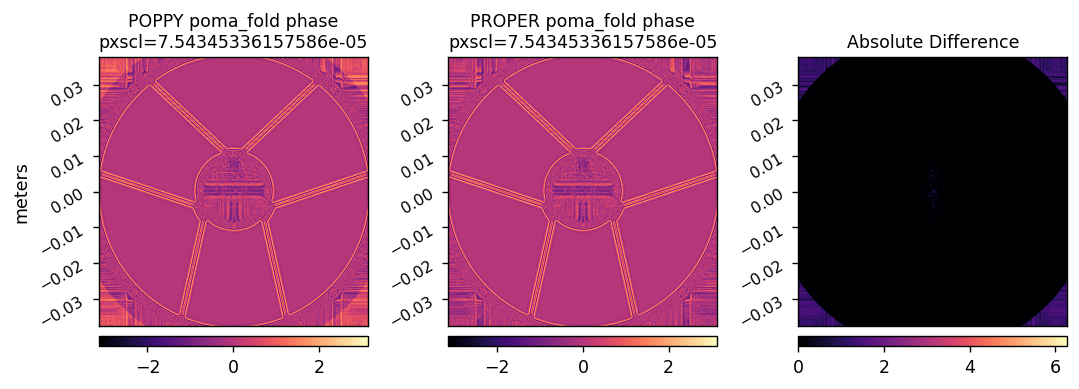

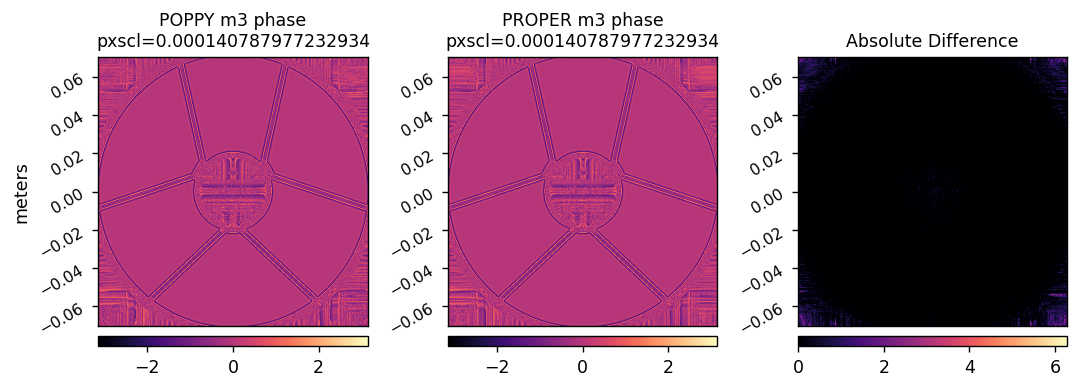

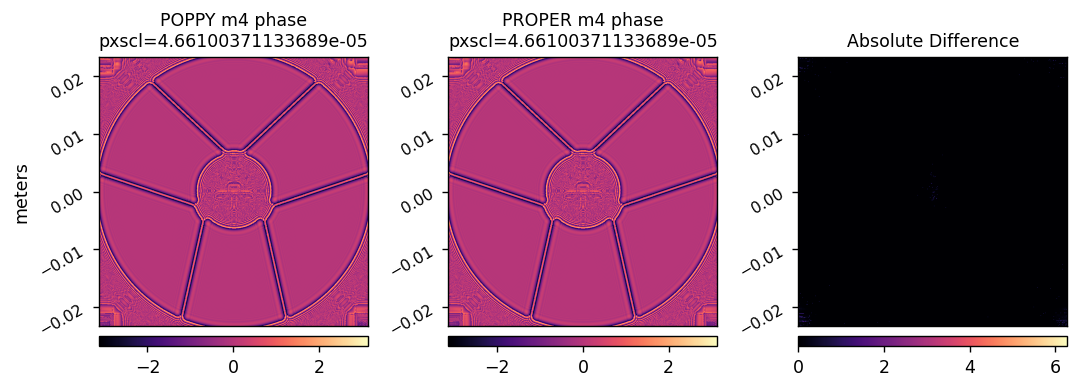

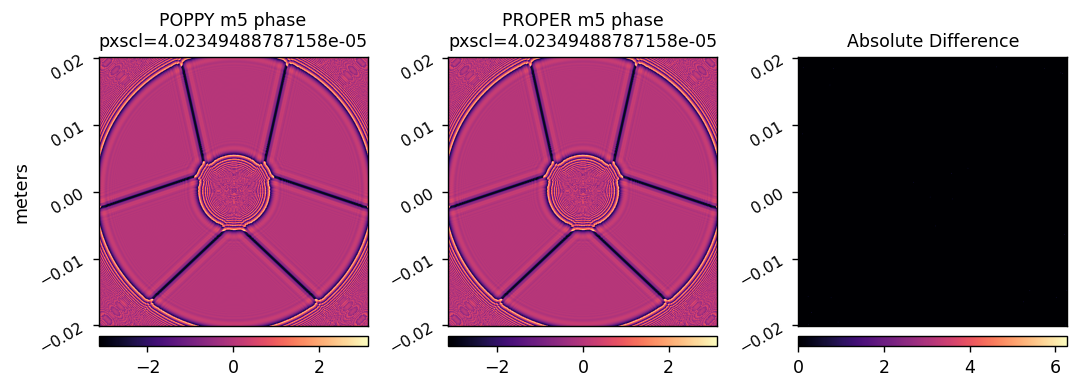

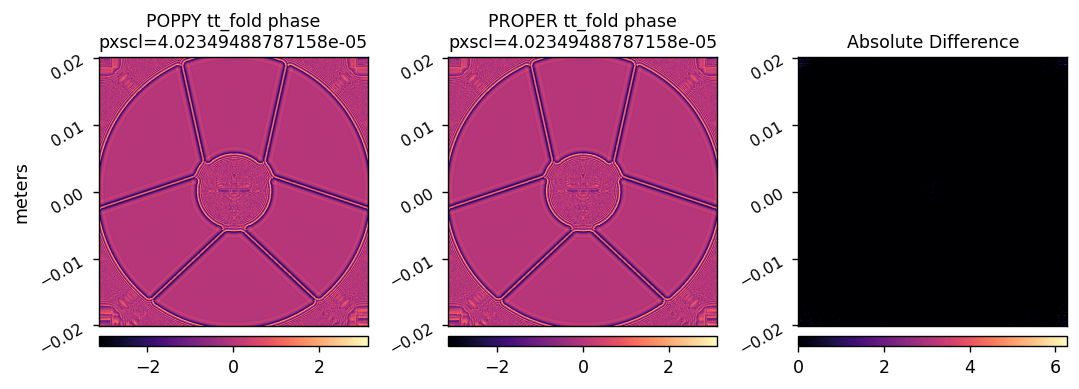

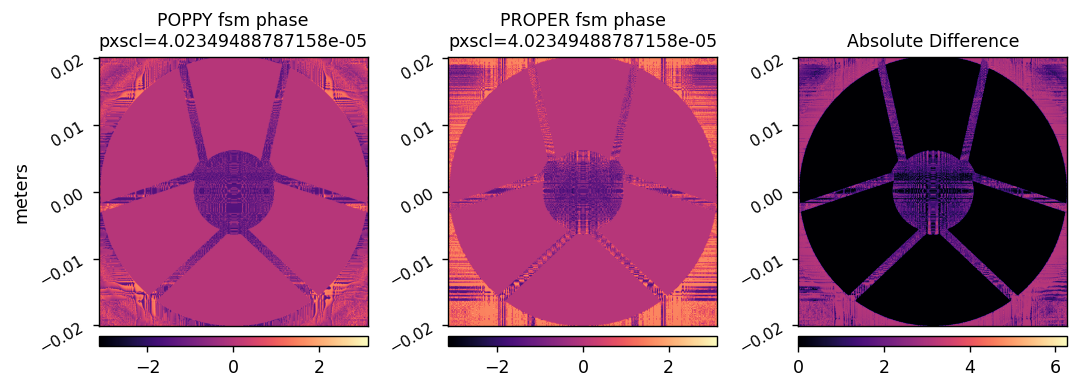

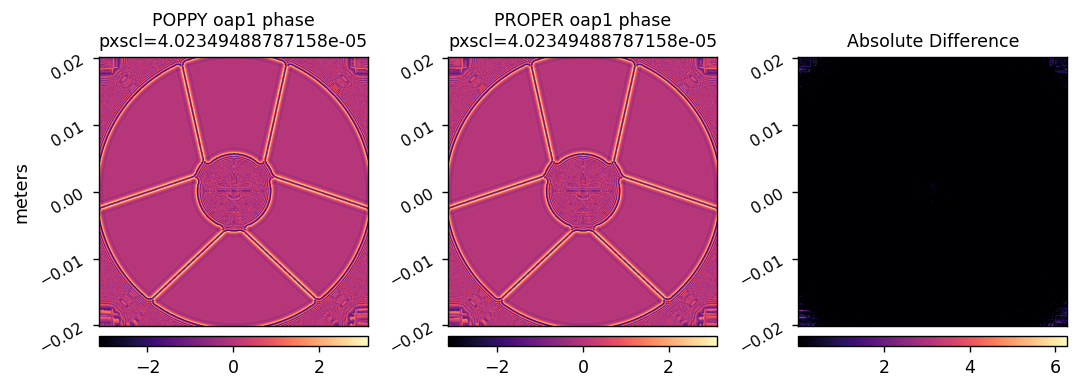

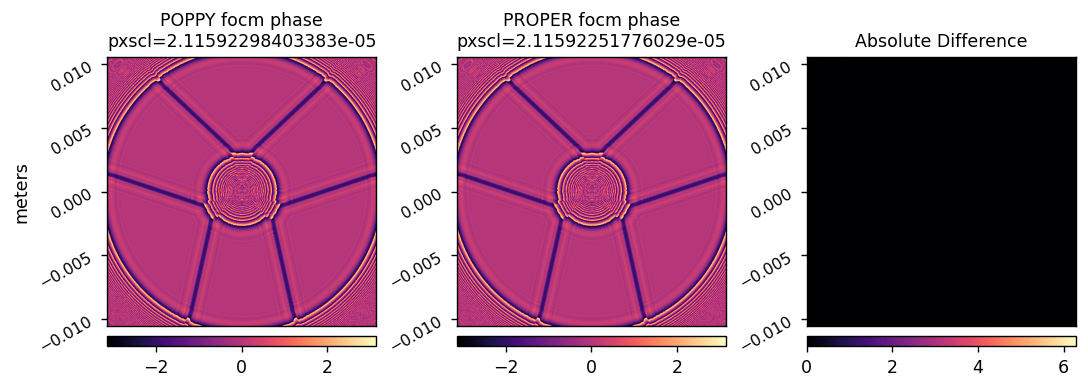

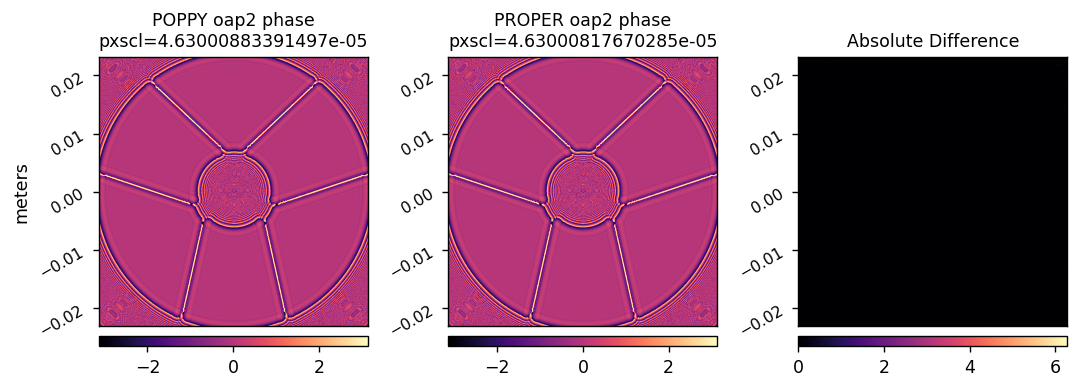

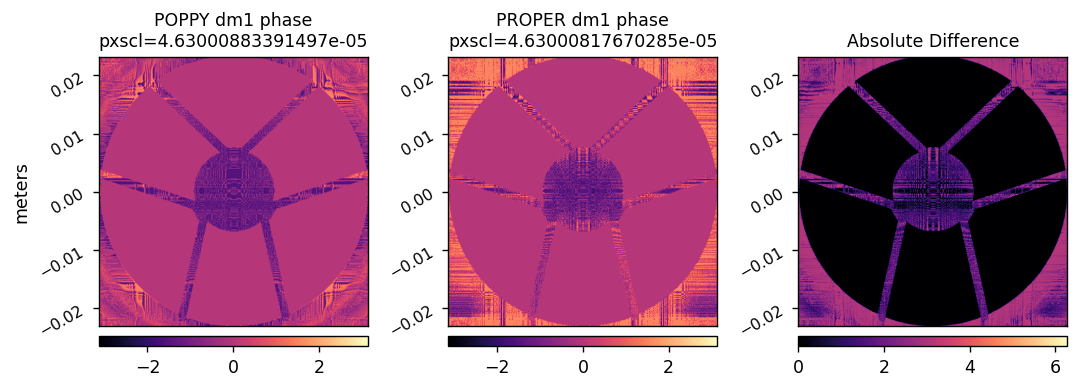

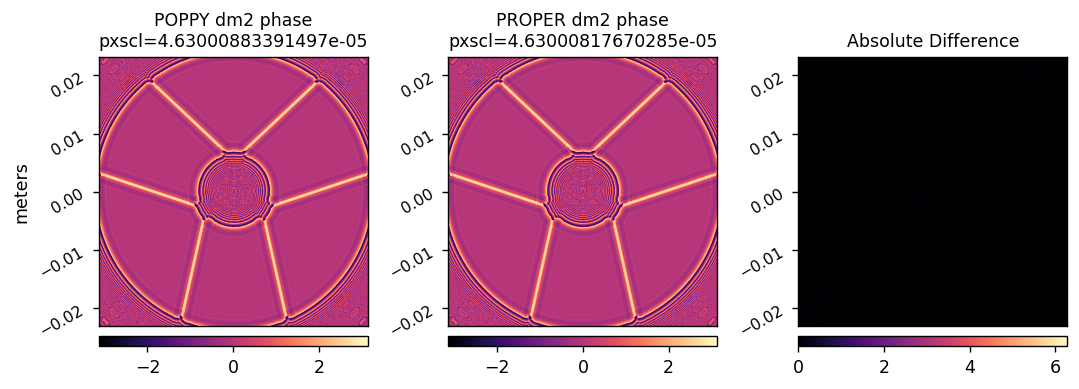

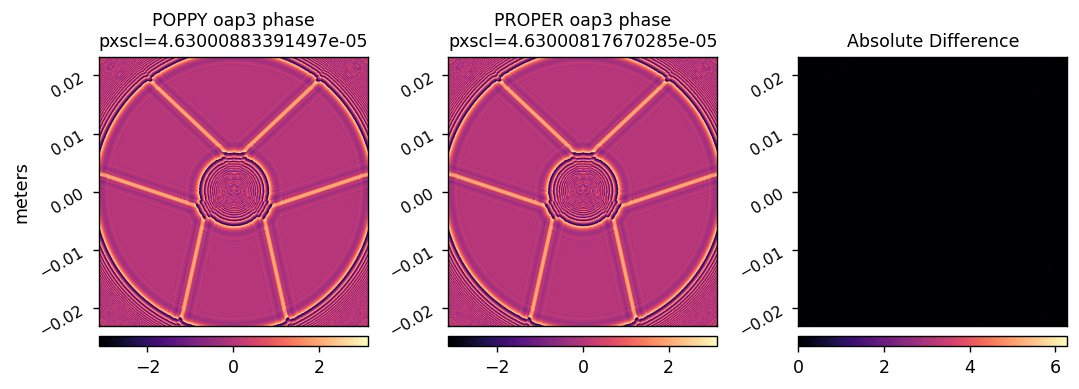

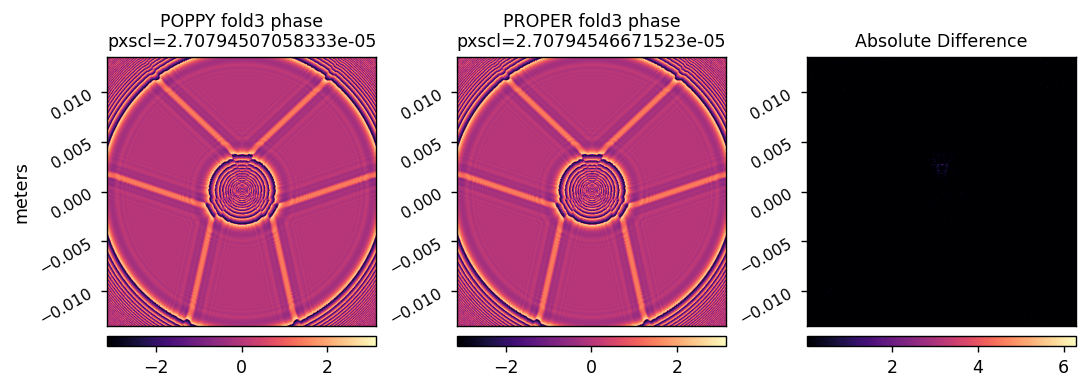

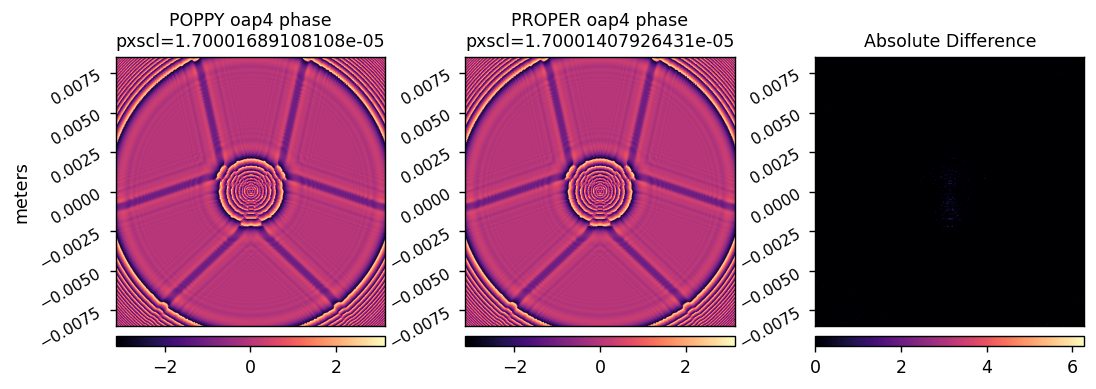

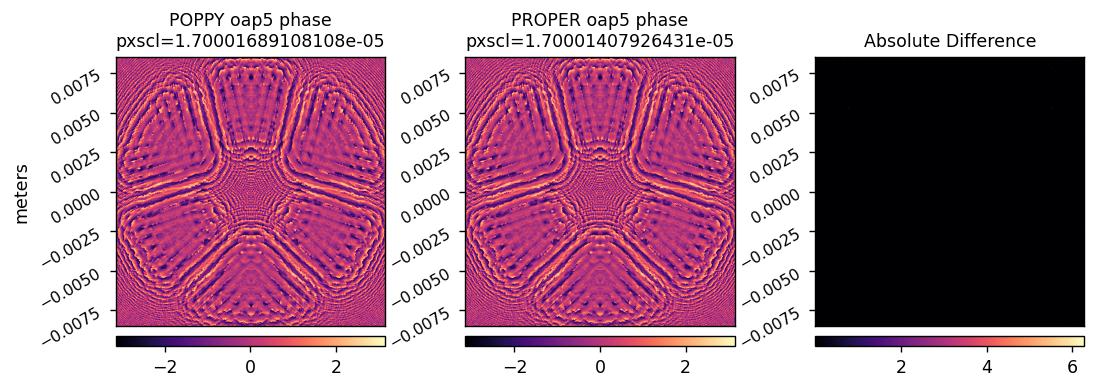

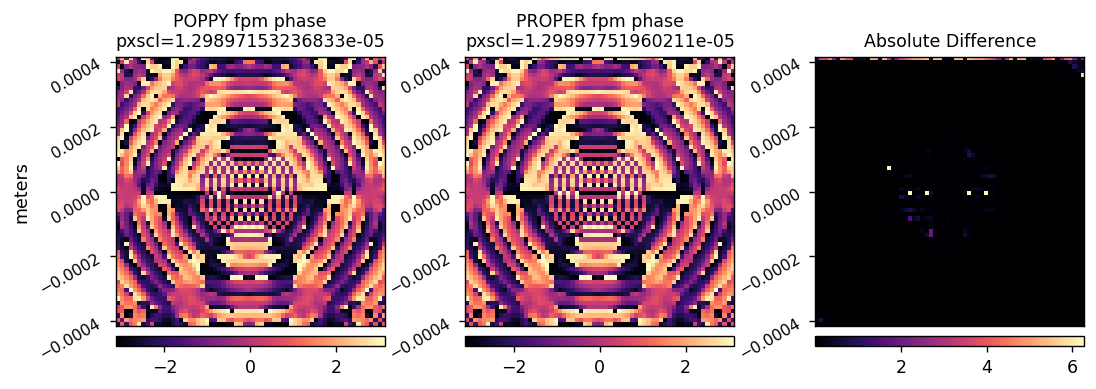

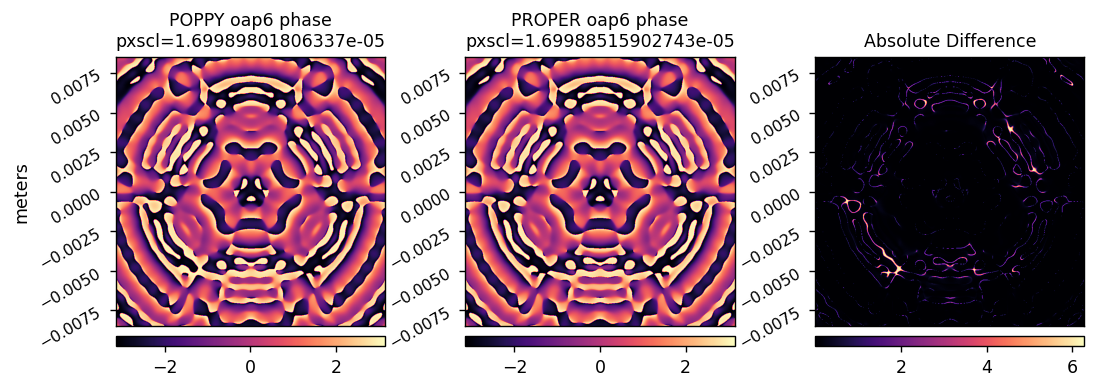

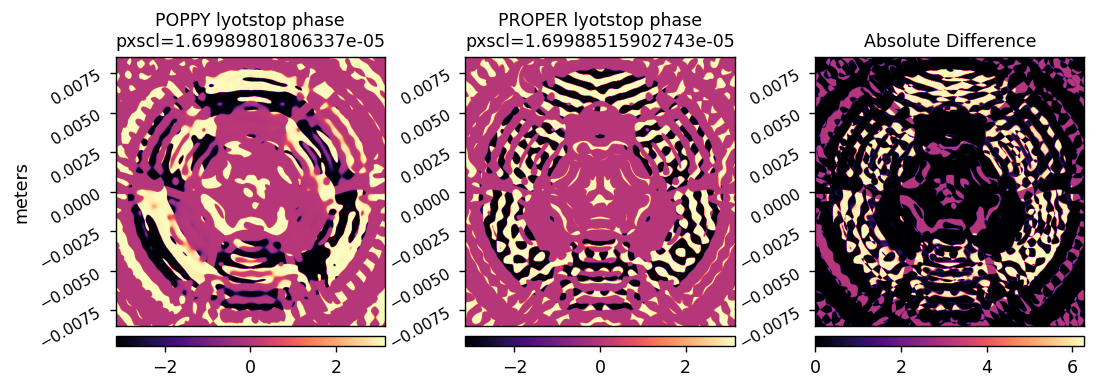

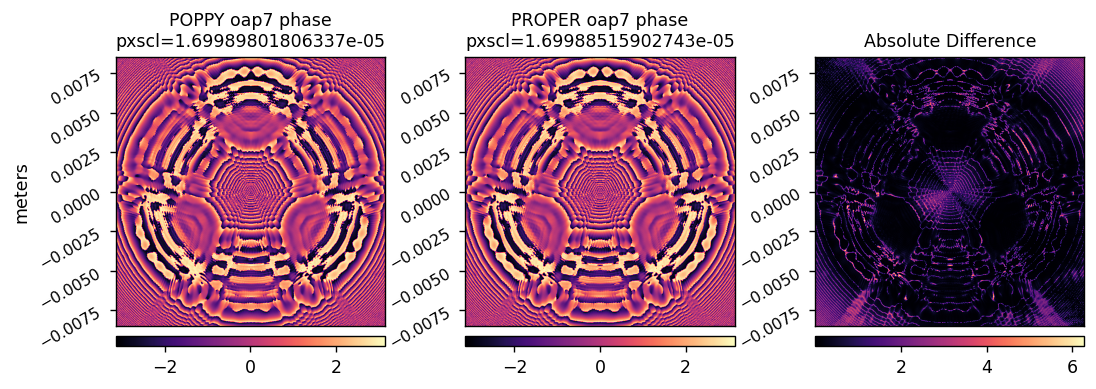

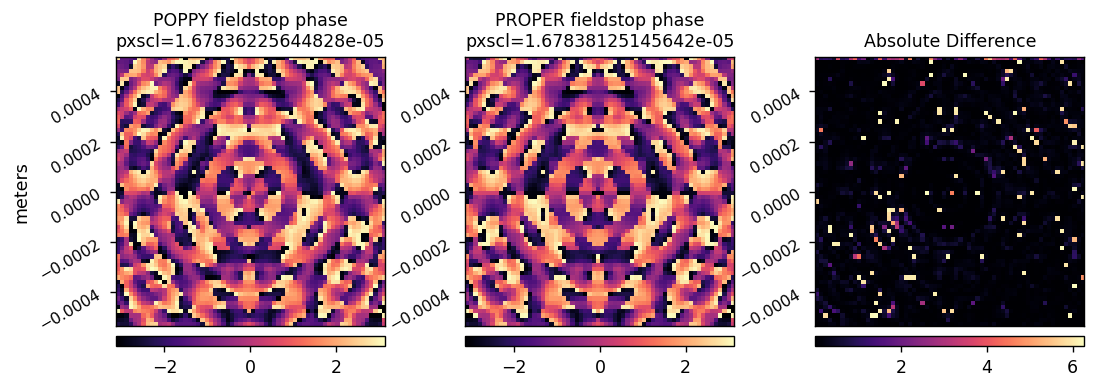

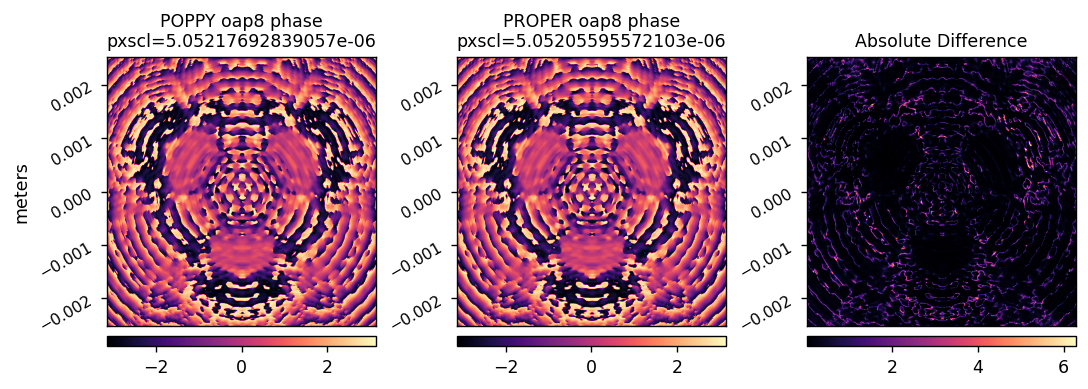

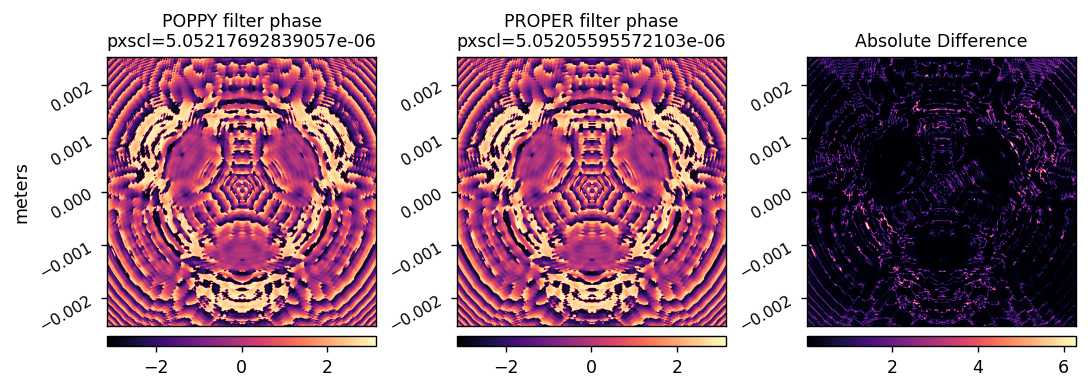

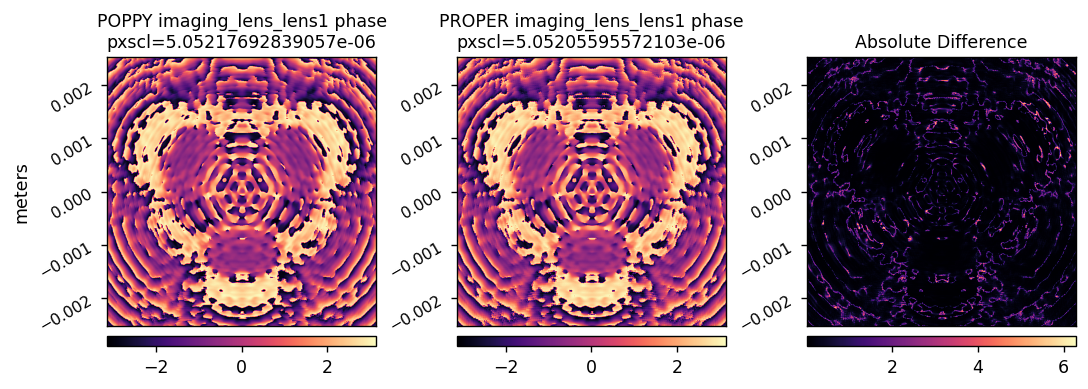

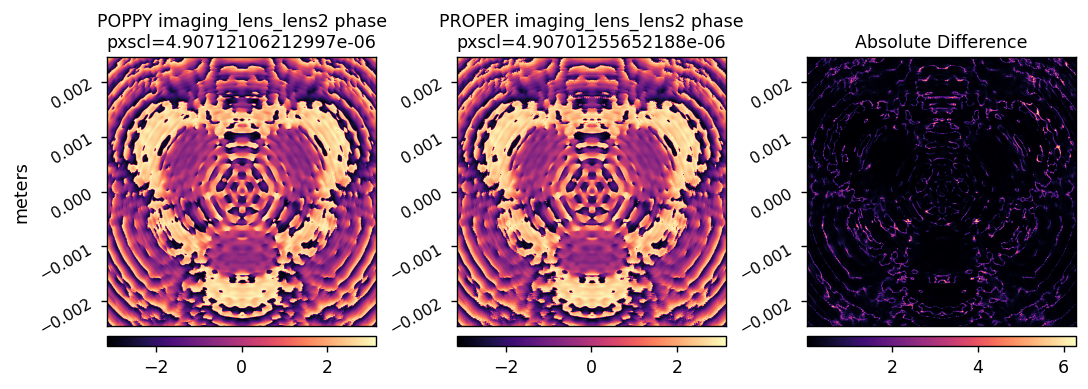

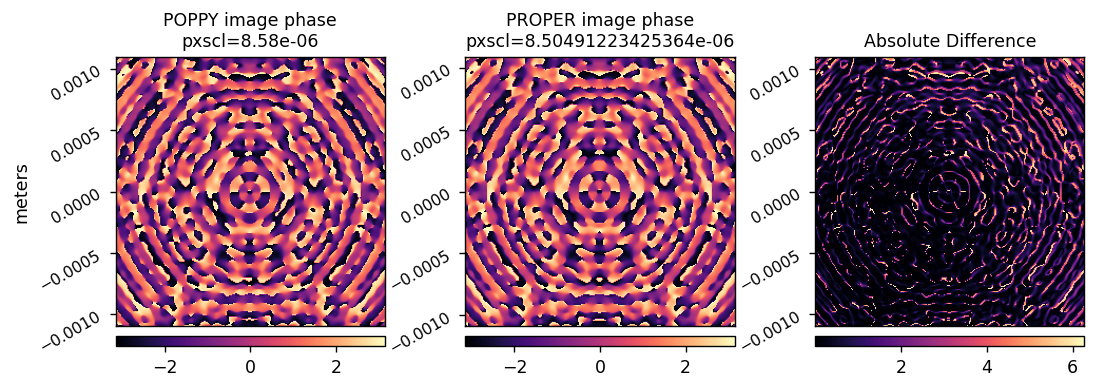

In [6]:
reload(misc)

show = 'intensity'
show = 'phase'

if show=='intensity': 
    data_ind = 0
    lognorm=True
elif show=='phase': 
    data_ind = 1
    lognorm=False
    
for i in range(len(poppy_fnames)):
    poppy_data = fits.getdata(poppy_fnames[i])[data_ind]
    poppy_pxscl = fits.getheader(poppy_fnames[i])['PIXELSCL']*u.m/u.pix
    
    proper_data = fits.getdata(proper_fnames[i])[data_ind]
    proper_pxscl = fits.getheader(proper_fnames[i])['PIXELSCL']*u.m/u.pix
    
    if 'fpm' in poppy_fnames[i] or 'fieldstop' in poppy_fnames[i]:
        poppy_data = rotate_180( misc.pad_or_crop(poppy_data, 64)  )
        proper_data = np.roll(misc.pad_or_crop(proper_data, 64), (-1,-1), axis=(0,1))
    elif 'image' in poppy_fnames[i]:
        poppy_data = rotate_180( misc.pad_or_crop(poppy_data, 256)  )
        proper_data = np.roll(misc.pad_or_crop(proper_data, 256), (-1,-1), axis=(0,1))
    else:
        poppy_data = misc.pad_or_crop(poppy_data, pupil_diam_pix)
        proper_data = misc.pad_or_crop(proper_data, pupil_diam_pix)
        
    optic = poppy_fnames[i][57:-11]
    
    misc.myimshow3(poppy_data, proper_data, np.abs( poppy_data-proper_data ),
                   'POPPY '+optic+' '+show+'\n'+'pxscl={}'.format(poppy_pxscl.value),
                   'PROPER '+optic+' '+show+'\n'+'pxscl={}'.format(proper_pxscl.value),
                   'Absolute Difference', titlesize=10,
                   pxscl1=poppy_pxscl, pxscl2=proper_pxscl, pxscl3=poppy_pxscl,
                   use_ylabel2=False, use_ylabel3=False,
                   lognorm1=lognorm, lognorm2=lognorm, lognorm3=lognorm, 
                   wspace=0.3)